# Contents 

01. Importing libraries and data
02. Time series analysis: decomposition
03. Testing for stationarity
04. Stationarizing SEDS data


### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. 

plt.style.use('fivethirtyeight') # This is a styling option for how plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'gSXWgTzDXw4LNyyscY-e'

In [3]:
# Importing annual data on energy consumed by the residential sector from Quandl

data = quandl.get('EIA/SEDS_TERCB_US_A')

In [4]:
data.head(5)

,Value
Date,
1960-12-31,9033190.0
1961-12-31,9280028.0
1962-12-31,9776931.0
1963-12-31,9982426.0
1964-12-31,10232757.0


In [5]:
data.shape

(60, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

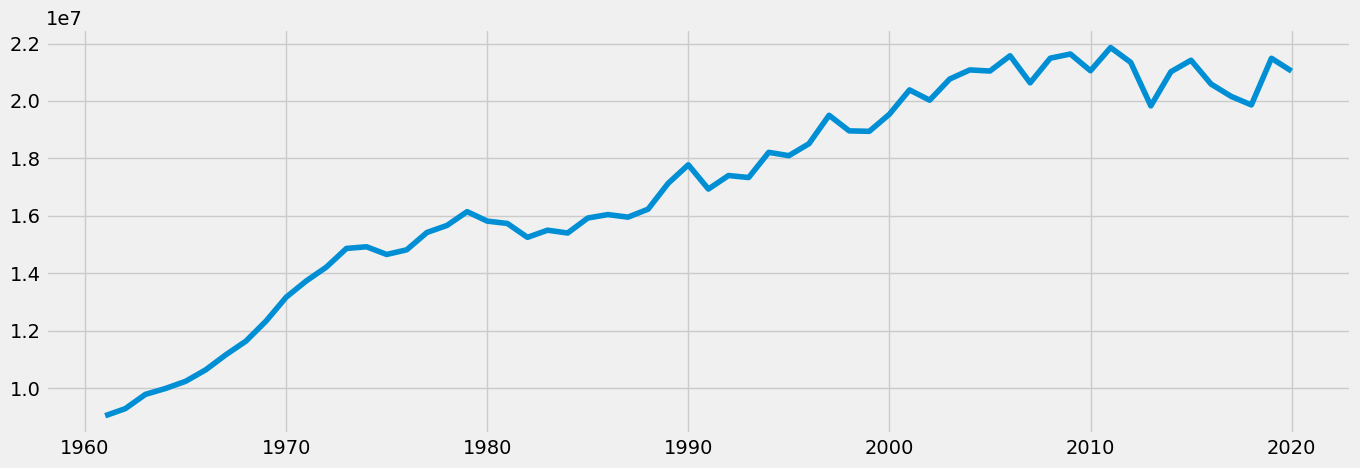

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful for saving RAM

plt.plot(data)

In [9]:
# Check for missing values 

data.isnull().sum() 

Value    0
dtype: int64

In [10]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

# No dups!

0

### 2. Time-series analysis: decomposition

In [11]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [12]:
from pylab import rcParams # Defines a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

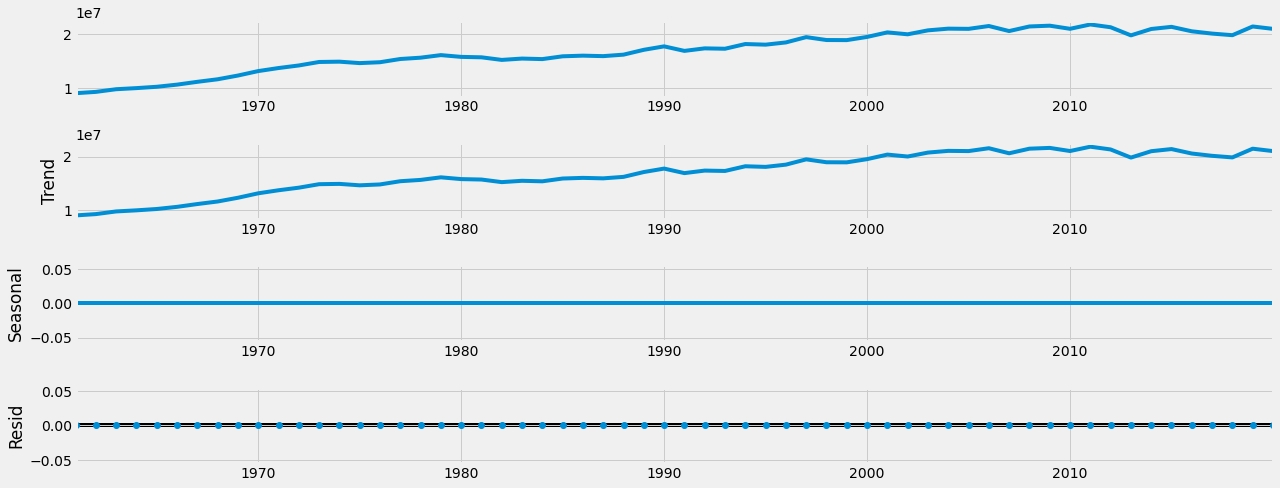

In [13]:
# Plot the separate components

decomposition.plot()
plt.show()

The time series does not seem to have very much noise or seasonality. It does however show a gradual upward trend in total energy consumption over the years. 

### 3. Testing for stationarity

In [14]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. Defining a function, prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series

dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.784781
p-value                         0.060481
Number of Lags Used             2.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


At an alpha of 0.05, the test statistic of -2.78 is not smaller than the critical value of -2.91, so therefore we can conclude that the time series is not stationary. 

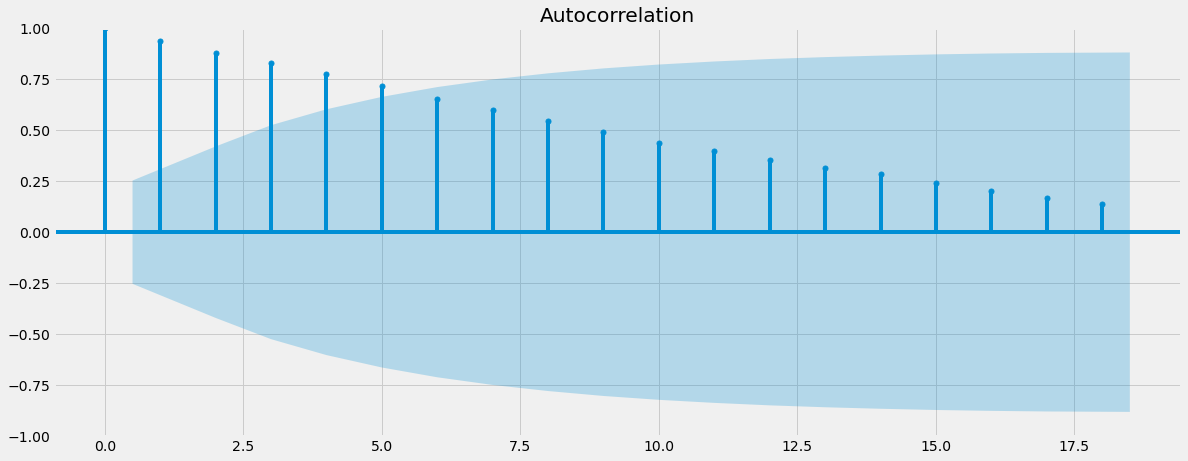

In [15]:
# plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # import the autocorrelation and partial correlation plots

plot_acf(data)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means there are lags that are significantly correlated with each other. Many lags beyond the interval means that the data is non-stationary and has a lot of autocorrelated data. We can conclude that this time series has a lot of autocorrelation. 

### 4. Stationarizing SEDS data

In [16]:
data_diff = data - data.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [17]:
data_diff.dropna(inplace = True) # removing the missing values that came about as a result of the differencing. 
# need to drop missing values to run the Dickey-Fuller test.

In [18]:
data_diff.head()

,Value
Date,
1961-12-31,246838.0
1962-12-31,496903.0
1963-12-31,205495.0
1964-12-31,250331.0
1965-12-31,399624.0


In [19]:
data_diff.columns

Index(['Value'], dtype='object')

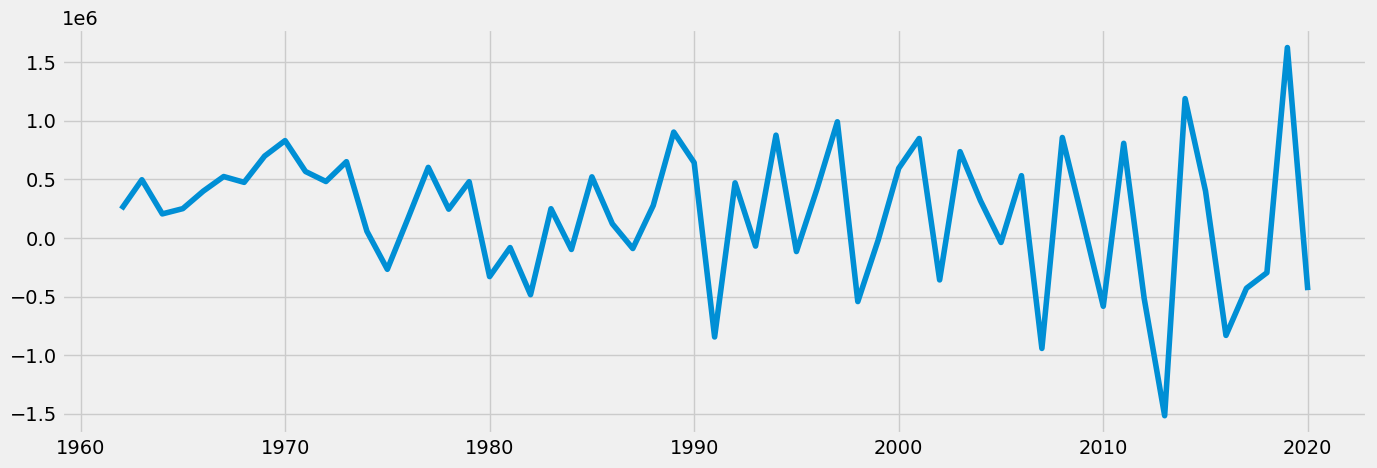

In [20]:
# Check the result of differencing on the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [21]:
# re-run the Dicker-Fuller test to check for stationarity 

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.846813e+00
p-value                        1.734373e-09
Number of Lags Used            1.000000e+00
Number of Observations Used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64


At an alpha of 0.05, the test statistic of -6.84e+00 is smaller than the critical value of -2.91e+00, so therefore we can reject the null hypothesis and conclude that the time series is now stationary. 

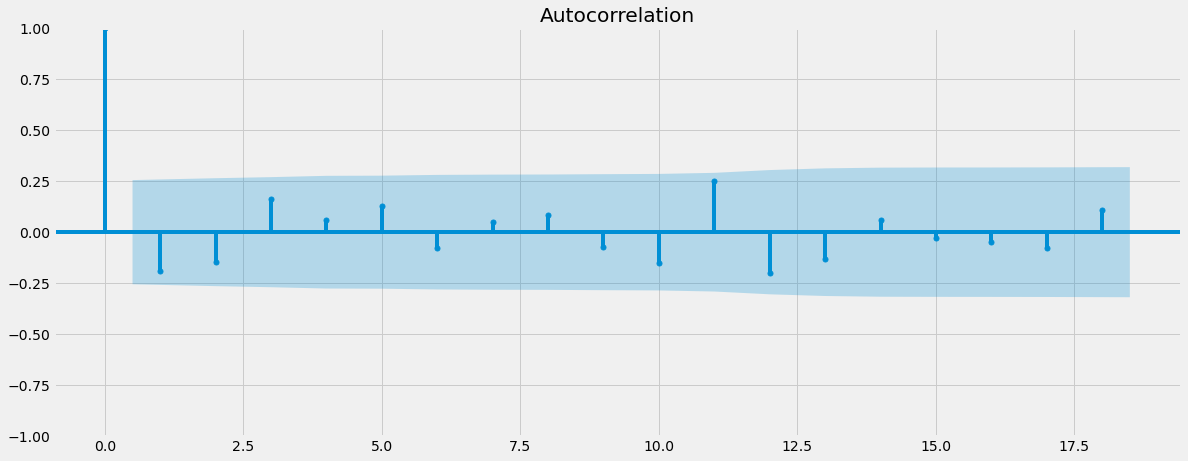

In [22]:
# checking for autocorrelation 

plot_acf(data_diff)
plt.show()

The autocorrelation plot has improved significantly and there appears to be no significant autocorrelations after one round of differencing. 